# tbcalc - Calculate resolution functions of toroidally bent crystal analysers

This notebook demostrates the use of `Analyser`, the main class of _tbcalc_ package to calculate the reflectivity curves of toroidally bent crystals.

In [1]:
import sys
import os.path

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(1, '..')
from tbcalc import Analyser, Quantity, TTscan

(The imported `Quantity` and `TTscan` are actually from _PyTTE_ but for convenience it can be imported via _tbcalc_ as well.)

## Basic usage

The characteristics of a TBCA can be passed either as keyword arguments or in a text file. The initialization of `Analyser` utilizes is built on the top of `TTcrystal` class of _pyTTE_. The mandatory keywords required by `TTcrystal` are `crystal`, `hkl`, and `thickness`. Also optional parameters of `TTcrystal` are supported (except for `fix_to_axes` as the shape of the crystal is fixed by the bending radii).

In addition, `Analyser` needs the meridional and sagittal bending radii `Rx` and `Ry` (or `R` for spherical bending) and the following keywords to determine the geometry of the crystal wafer:

- **Circular analyser**  `diameter`
- **Rectangular analyser** `a`, `b`
- **Strip-bent analyser** `diameter`, `strip_width`, `strip_orientation` (optional)

In the following we define a spherically bent crystal analyser with the minimum number of parameters:

In [2]:
kwargs = {
         'crystal'   : 'Si',
         'hkl'       : [6,6,0],
         'thickness' : Quantity(150,'um'),
         'R'         : Quantity(1, 'm'),
         'diameter'  : Quantity(100,'mm'),
         }

analyser = Analyser(**kwargs)

print(analyser)

CRYSTAL PARAMETERS
------------------

Crystal: Si
Crystallographic parameters:
    a = 0.543069 nm,  b = 0.543069 nm,  c = 0.543069 nm
    alpha = 90.0 deg,  beta = 90.0 nm,  gamma = 90.0 deg
Direct primitive vectors (before rotations, in nm):
    a1 = [0.5431 0.     0.    ]
    a2 = [0.     0.5431 0.    ]
    a3 = [0.     0.     0.5431]
Reciprocal primitive vectors (before rotations, in 1/nm):
    b1 = [11.5698 -0.     -0.    ]
    b2 = [ 0.     11.5698 -0.    ]
    b3 = [ 0.      0.     11.5698]

Reflection: [6, 6, 0]
Asymmetry angle: 0 deg
In-plane rotation angle: 0 deg
Crystal directions parallel to the Cartesian axes (after rotations):
    x || [ 0.7071 -0.7071 -1.    ]
    y || [-0.7071  0.7071 -1.    ]
    z || [ 1.  1. -0.]

Crystal thickness: 150 um
Debye-Waller factor: 1.0

Deformation model: anisotropic toroidal, fixed shape (built-in)
Meridional bending radius: 1 m
Sagittal bending radius: 1 m
Material elastic isotropy: anisotropic
Compliance matrix S (with rotations appli

Note that for parameters with physical dimensions, `Quantity` class is used to avoid manual unit conversion errors. An exception in this rule is the positional arguments to stress and strain tensor component functions, the contact force function and the transverse shift function, which are assumed to be in mm.

To calculate the reflectivity curve of the analyser, we define a `TTscan` object and pass it as a parameter to `Analyser.run()`. In the following example, we perform an energy scan at the incidence angle of 88$^\circ$ with $\sigma$-polarized beam. (Note that the progress of the solver is not updated in the Jupyter notebook.)

In [3]:
ttscan = TTscan(constant = Quantity(88,'deg'), scan = 150, polarization = 'sigma')
          
scan_vec, reflectivity = analyser.run(ttscan)


Solving the 1D Takagi-Taupin equation for Si(6,6,0) reflection
---------------------------------------------------------------

Using automatically determined scan limits:
E min: -398.53818401959984 meV
E max: 497.8245636614505 meV

The direction of diffraction out of the crystal -> Bragg case
Solving for sigma-polarization
Asymmetry angle : 0.0 deg
Wavelength      : 0.12792485810476428 nm
Energy          : 9.691954701912818 keV
Bragg angle     : 88.0 deg
Incidence angle : 88.0 deg
Exit angle      : 88.0 deg

Structure factors
F0   : (113.63467647633642+1.8803249291613136j)
Fh   : (32.56212714824987+1.8803249291612771j)
Fb   : (32.56212714824987+1.880324929161349j)

Susceptibilities
chi0 : (-1.0414423958094404e-05+1.7232856728674413e-07j)
chih : (-2.984263321855525e-06+1.7232856728674085e-07j)
chib : (-2.9842633218555247e-06+1.7232856728674744e-07j)

(Mean F and chi values for energy scan)

Transmission in the Bragg case not implemented!

Calculating the TT-curve using 4 cores.
Solvin

`Analyser.run()` returns the values of the scan points (for automatically determined limits in units meV or µrad) and the calculated reflectivity curve of the analyser. However, the full result with different components of the spectrum, deformation fields and metadata can be accessed via `analyser.solution`. For example, in the following example we compare the different components of the reflectivity curve and plot the energy shifts due to transverse strain as a function of surface position:

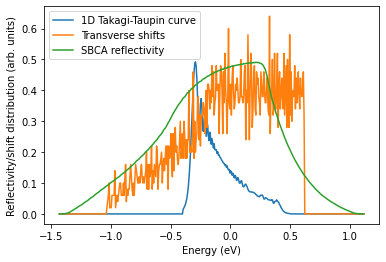

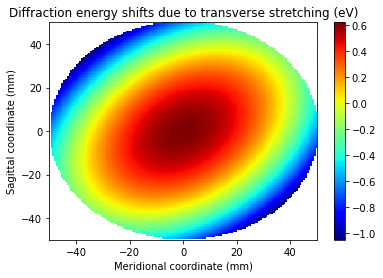

In [4]:
s = analyser.solution

plt.figure()
plt.plot(s['scan'].in_units('eV'),s['tt_curve'], label='1D Takagi-Taupin curve')
plt.plot(s['scan'].in_units('eV'),s['shift_curve']*0.01, label='Transverse shifts')
plt.plot(s['scan'].in_units('eV'),s['total_curve']*0.75e4, label='SBCA reflectivity')
plt.legend()
plt.xlabel('Energy (eV)')
plt.ylabel('Reflectivity/shift distribution (arb. units)')

#Define a grid over the analyser surface (units in mm, this can be checked in solution['length_scale'])
x = np.linspace(-50,50,150) 
X,Y = np.meshgrid(x,x)

plt.figure()
plt.pcolormesh(X,Y,s['shift_function'](X,Y).in_units('eV'),cmap='jet')
plt.title('Diffraction energy shifts due to transverse stretching (eV)')
plt.xlabel('Meridional coordinate (mm)')
plt.ylabel('Sagittal coordinate (mm)')
plt.colorbar()

plt.show()

Note that the y-axes of the curves mean different things for different components and thus need to be renormalized for a sensible comparison. 

Also, it is good to note that the high noise in the transverse shift curve results from histogramming the shifts calculated over a gridded surface of the analyser and is not a direct indication of the precision of the calculated transverse shift distribution. For prettier presentation averaging should be applied.

However, for quicker plotting `Analyser.plot()` is provided:

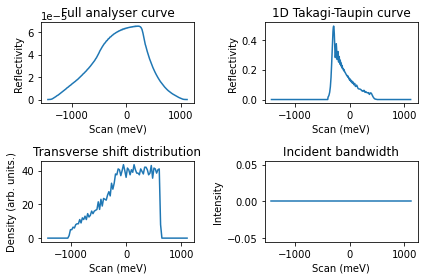

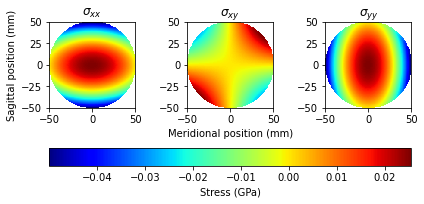

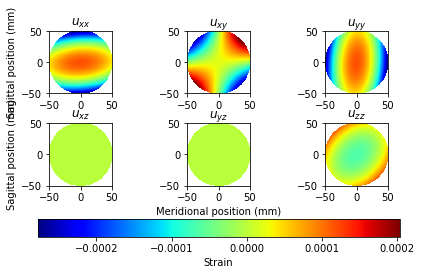

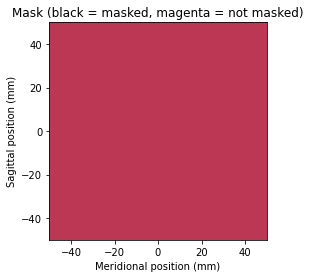

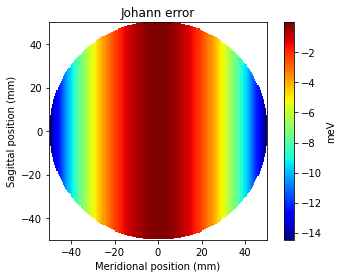

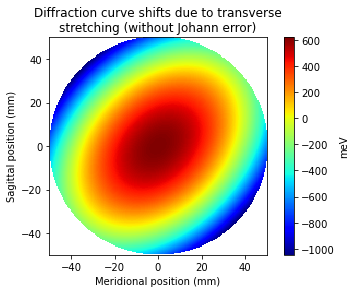

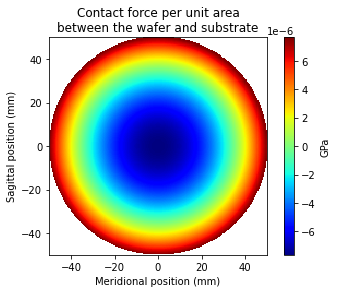

In [5]:
analyser.plot('all') #for individual options see help(analyser.plot)

Finally, the solution can be save on the disk in the plain text format with `analyser.save('filename.dat')`

## Masking, Johann error, and incident bandwidth

As the contribution of transverse streching to the diffraction energy or angle varies mostly radially, the resolution of the analyser can be improved by masking out the edges of the analyser. This can be simulated by defining a function which returns `True` at positions which are not masked and `False` at positions that are. 


Solving the 1D Takagi-Taupin equation for Si(6,6,0) reflection
---------------------------------------------------------------

Using automatically determined scan limits:
E min: -398.53818401959984 meV
E max: 497.8245636614505 meV

The direction of diffraction out of the crystal -> Bragg case
Solving for sigma-polarization
Asymmetry angle : 0.0 deg
Wavelength      : 0.12792485810476428 nm
Energy          : 9.691954701912818 keV
Bragg angle     : 88.0 deg
Incidence angle : 88.0 deg
Exit angle      : 88.0 deg

Structure factors
F0   : (113.63467647633642+1.8803249291613136j)
Fh   : (32.56212714824987+1.8803249291612771j)
Fb   : (32.56212714824987+1.880324929161349j)

Susceptibilities
chi0 : (-1.0414423958094404e-05+1.7232856728674413e-07j)
chih : (-2.984263321855525e-06+1.7232856728674085e-07j)
chib : (-2.9842633218555247e-06+1.7232856728674744e-07j)

(Mean F and chi values for energy scan)

Transmission in the Bragg case not implemented!

Calculating the TT-curve using 4 cores.
Solvin

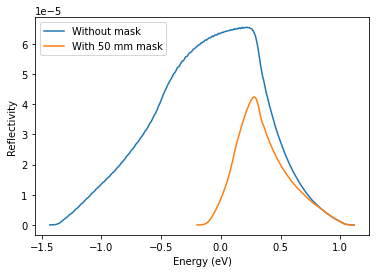

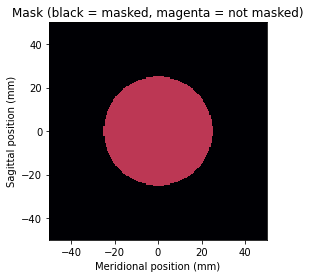

In [9]:
#store the previous solution
E0, I0 = s['scan'].in_units('eV'), s['total_curve']

#define a mask function with a circular aperture of 50 mm in diameter
#Note that units are in mm
def mask_50mm(X,Y):
    return X**2 + Y**2 < 25**2

#Repeat the previous calculation with the mask
analyser.run(ttscan, mask = mask_50mm)

plt.plot(E0, I0, label = 'Without mask')
plt.plot(analyser.solution['scan'].in_units('eV'), analyser.solution['total_curve'], label = 'With 50 mm mask')
plt.xlabel('Energy (eV)')
plt.ylabel('Reflectivity')
plt.legend()
plt.show()

analyser.plot('mask')

Johann error is included in the calculations by default but can be turned of by passing `include_johann_error = False` to `Analyser.run()`.


Solving the 1D Takagi-Taupin equation for Ge(5,5,5) reflection
---------------------------------------------------------------

Using automatically determined scan limits:
E min: -521.3610401010584 meV
E max: 628.8056243710256 meV

The direction of diffraction out of the crystal -> Bragg case
Solving for pi-polarization
Asymmetry angle : 0.0 deg
Wavelength      : 0.12866601308199435 nm
Energy          : 9.63612612454147 keV
Bragg angle     : 80.0 deg
Incidence angle : 80.0 deg
Exit angle      : 80.0 deg

Structure factors
F0   : (242.16414896673766+5.269718999058836j)
Fh   : (38.05333492639566-32.78361592733699j)
Fb   : (32.783615927336825+38.053334926395806j)

Susceptibilities
chi0 : (-1.9860049661707024e-05+4.321733067057941e-07j)
chih : (-3.1207803659475322e-06-2.6886070592417515e-06j)
chib : (-2.6886070592417375e-06+3.1207803659475445e-06j)

(Mean F and chi values for energy scan)

Transmission in the Bragg case not implemented!

Calculating the TT-curve using 4 cores.
Solving...0

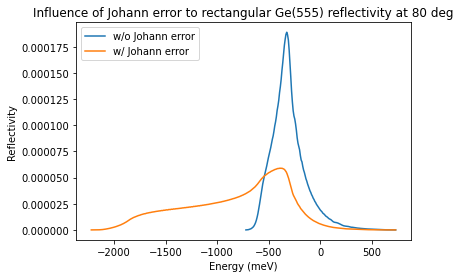

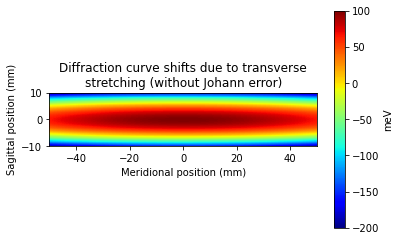

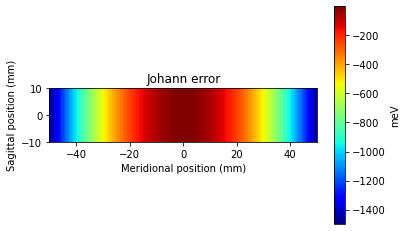

In [14]:
kwargs = {
         'crystal'   : 'Ge',
         'hkl'       : [5,5,5],
         'thickness' : Quantity(150,'um'),
         'R'         : Quantity(0.5, 'm'),
         'a'  : Quantity(100,'mm'),
         'b'  : Quantity(20,'mm'),
}

analyser = Analyser(**kwargs)
ttscan = TTscan(constant = Quantity(80,'deg'), scan = 150, polarization = 'pi')
E,I = analyser.run(ttscan,include_johann_error = False)

E2,I2 = analyser.run(ttscan)

plt.plot(E,I,label = 'w/o Johann error')
plt.plot(E2,I2,label = 'w/ Johann error')
plt.xlabel('Energy (meV)')
plt.ylabel('Reflectivity')
plt.title('Influence of Johann error to rectangular Ge(555) reflectivity at 80 deg')
plt.legend()

analyser.plot('shifts')
analyser.plot('johann_error')

The default assumption is that the bandwidth of the incident radiation is infinitely narrow which is not true in practice. The bandwidth, with which the analyser curve is convolved, can be passed to `run()` as a parameter `incident_bandwidth`. The parameter should be given as a tuple whose first element is the scan values (energy or angel) wrapped in a Quantity instance and the second is a Numpy array of the corresponding intensities. In the following example, we use _PyTTE_ to calculate the reflectivity of a single Si(444) monochromator and use it as the incident bandwidth: 


Solving the 1D Takagi-Taupin equation for Si(4,4,4) reflection
---------------------------------------------------------------

Using automatically determined scan limits:
E min: -35.0423948581302 meV
E max: 187.9150106809532 meV

The direction of diffraction out of the crystal -> Bragg case
Solving for sigma-polarization
Asymmetry angle : 0.0 deg
Wavelength      : 0.12683025309720847 nm
Energy          : 9.775600850135724 keV
Bragg angle     : 54.0 deg
Incidence angle : 54.0 deg
Exit angle      : 54.0 deg

Structure factors
F0   : (113.6164613089208+1.8494188403966527j)
Fh   : (41.384730026784474+1.8494188403966072j)
Fb   : (41.384730026784474+1.849418840396699j)

Susceptibilities
chi0 : (-1.023532088054563e-05+1.6660785819158466e-07j)
chih : (-3.7282096845735155e-06+1.6660785819158053e-07j)
chib : (-3.7282096845735155e-06+1.666078581915888e-07j)

(Mean F and chi values for energy scan)

Transmission in the Bragg case not implemented!

Calculating the TT-curve using 4 cores.
Solving.

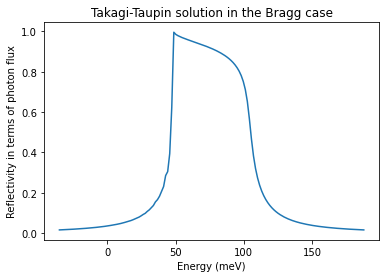


Solving the 1D Takagi-Taupin equation for Si(6,6,0) reflection
---------------------------------------------------------------

Using automatically determined scan limits:
E min: -401.95013895981947 meV
E max: 476.62643797560133 meV

The direction of diffraction out of the crystal -> Bragg case
Solving for sigma-polarization
Asymmetry angle : 0.0 deg
Wavelength      : 0.12683025309720844 nm
Energy          : 9.775600850135726 keV
Bragg angle     : 82.2387560929649 deg
Incidence angle : 82.2387560929649 deg
Exit angle      : 82.2387560929649 deg

Structure factors
F0   : (113.61646975661343+1.849433462061472j)
Fh   : (32.54392042852686+1.8494334620614359j)
Fb   : (32.54392042852686+1.8494334620615072j)

Susceptibilities
chi0 : (-1.0235321641569542e-05+1.6660917540767723e-07j)
chih : (-2.9317711928312147e-06+1.6660917540767403e-07j)
chib : (-2.9317711928312143e-06+1.6660917540768048e-07j)

(Mean F and chi values for energy scan)

Transmission in the Bragg case not implemented!

Calculat

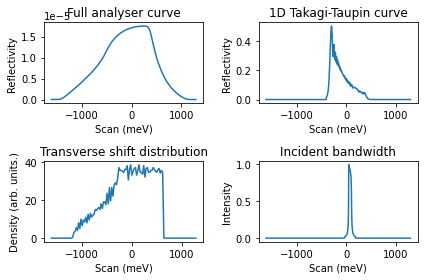

In [35]:
from pyTTE import TakagiTaupin, TTscan, TTcrystal

#Calculate the incident bandwidth
monox = TTcrystal(crystal ='Si', hkl = [4,4,4], thickness = Quantity(1,'mm'))
monos = TTscan(constant = Quantity(54,'deg'), scan = 150, polarization = 'sigma' )

tt = TakagiTaupin(monox,monos)
tt.run()
tt.plot()

#Calculate the resolution function of the analyser + incident bandwidth
kwargs = {
         'crystal'   : 'Si',
         'hkl'       : [6,6,0],
         'thickness' : Quantity(150,'um'),
         'R'         : Quantity(1, 'm'),
         'diameter'  : Quantity(100,'mm'),
         }

analyser = Analyser(**kwargs)

#Calculate the Bragg angle of the analyser for the indicent beam energy
analyser_th = analyser.crystal_object.bragg_angle(monox.bragg_energy(Quantity(54,'deg')))

anas = TTscan(constant = analyser_th, scan = 150, polarization = 'sigma')
analyser.run(anas, incident_bandwidth=[tt.solution['scan'],tt.solution['reflectivity']])

analyser.plot('curves')